##### Name: Mr. Klaus Sipope
##### Position: Data Scientist
##### Name of Program: Movie Recommendation System.ipynb
##### Description: Build a Movie Recommendation System with Machine Learning and Python
##### Date first written: Thu, 19-Oct-2023
##### Date last updated: Fri, 10-Nov-2023

# Introduction

In this notebook, we will implement a few recommendation algorithms such as content based, popularity based and collaborative filtering and try to build an ensemble of these models to come up with our final recommendation system. 

With us, we have two MovieLens datasets: 
- The Full Dataset: it consists of 26,000,000 ratings and 750,000 tag applications applied to 45,000 movies by 270,000 users. It includes tag genome data with 12 million relevance scores across 1,100 tags. 
- The Small Dataset: it comprises of 100,000 ratings and 1,300 tag applications applied to 9,000 movies by 700 users.

## Imports

In [1]:
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, NormalPredictor, BaselineOnly, KNNBasic, NMF
from surprise.model_selection import cross_validate, KFold ,GridSearchCV , RandomizedSearchCV

import warnings; warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('D:\APU\Semester 3\CP2\Dataset\movies_dataset\movies_metadata.csv')
df.head().transpose()

,0,1,2,3,4
adult,False,False,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"{'id': 96871, 'name': 'Father of the Bride Col..."
budget,30000000,65000000,0,16000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 35, 'name': 'Comedy'}]"
homepage,http://toystory.disney.com/toy-story,NaN,NaN,NaN,NaN
id,862,8844,15602,31357,11862
imdb_id,tt0114709,tt0113497,tt0113228,tt0114885,tt0113041
original_language,en,en,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...,"Cheated on, mistreated and stepped on, the wom...",Just when George Banks has recovered from his ...


## Understanding the dataset

In [3]:
df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [4]:
df.shape

(45466, 24)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

The dataset contains a total of 45,466 movies with 24 features. Majority of the features have very few NaN values (apart from homepage and tagline). We will attempt at cleaning this dataset to a form suitable for analysis in the preprocessing section.

# Data Preprocessing

In this section will be discussed the preprocessing of the movies_metadata dataset.

### Feature Dropping

In [6]:
df = df.drop(['imdb_id'], axis=1)

In [7]:
df[df['original_title'] != df['title']][['title', 'original_title']].head()

,title,original_title
28,The City of Lost Children,La Cité des Enfants Perdus
29,Shanghai Triad,摇啊摇，摇到外婆桥
32,Wings of Courage,"Guillaumet, les ailes du courage"
57,The Postman,Il postino
58,The Confessional,Le confessionnal


The feature 'original_title' refers to the title of a movie in the native language in which that movie was produced. It is preferable to use the translated (english title) in this analysis and hence, drop column original_title. By looking at the original_language feature, we will be able to deduce if a movie is a foreign language film, so no important information is lost in doing so.

In [8]:
df = df.drop('original_title', axis=1)

### Revenue & Budget Handling

In [9]:
df[df['revenue'] == 0].shape

(38052, 22)

It is found that the column 'revenue' contains a lot of zero as value. Many movies lacked revenue information, these entries will be replaced by NaN, marking them for special attention to avoid skewing subsequent analyses and computations.

In [10]:
df['revenue'] = df['revenue'].replace(0, np.nan)

The column 'budget' contains some unclean values that makes Pandas assign it as a generic object. To solve this, we convert the column into a numeric variable and replace all the non-numeric values with NaN. Finally, as with 'revenue' feature, we will convert all the values of zero into NaN to indicate the absence of information regarding budget.

In [11]:
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df[df['budget'].isnull()].shape

(36576, 22)

### Feature Engineering

Two significant new features, ‘year’ and 'return’, will be created to improve the analysis of the dataset. 
- year: will be obtained by extracting the release year from the ‘release_date’ column, providing a categorical temporal attribute. 

- return: will be obtained from the calculation of the ratio of revenue to budget. It was created to evaluate the financial performance of movies more accurately.

In [12]:
df['return'] = df['revenue'] / df['budget']
df[df['return'].isnull()].shape

(40085, 23)

In [13]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: 
                                                                       str(x).split('-')[0] if x != np.nan else np.nan)

### Additional Cleansing

In [14]:
df['adult'].value_counts()

adult
False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: count, dtype: int64

The ‘adult’ column will be dropped from the dataset due to the fact that it contains mainly ‘False’ entries, with minimal counts of ‘True’ and some irrelevant text data that are considered as input errors.

In [15]:
df = df.drop('adult', axis=1)

# EDA

### Title and Overview Wordclouds

To identify prevailing themes and popular words that could significantly impact the recommendation process, an EDA of the features 'title' and 'overview' is realized. By understanding the recurrent themes and commonly used terms, the model can be fine-tuned to capture and prioritize these prevalent aspects in movie suggestions.

In [16]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')

In [17]:
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])

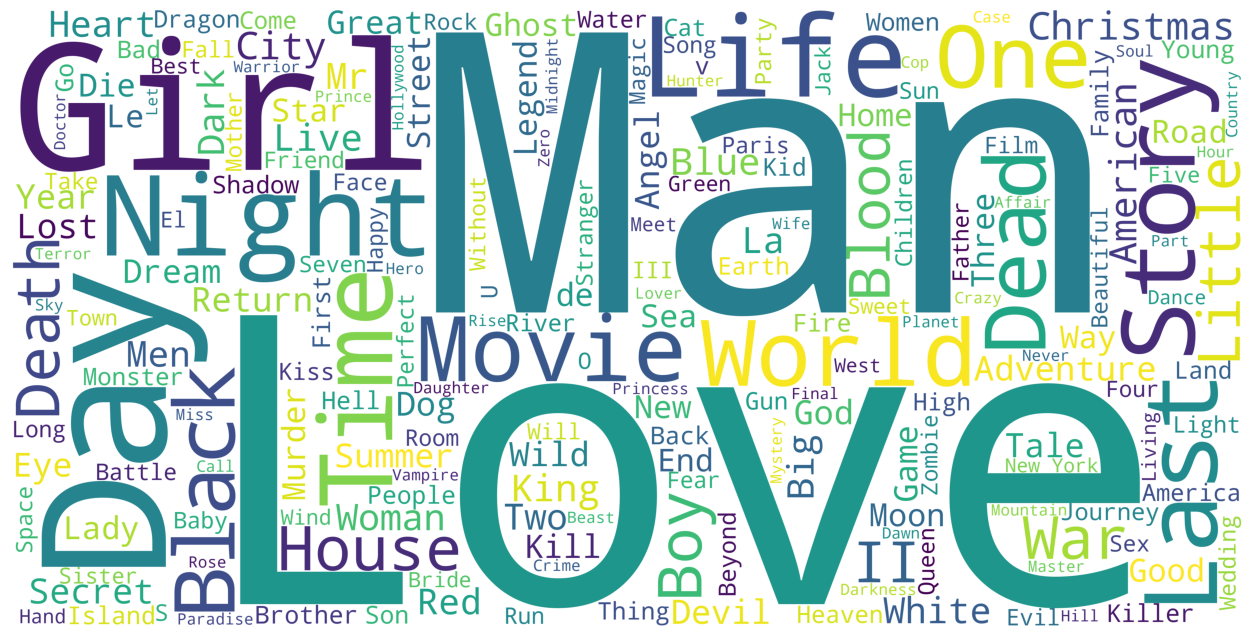

In [18]:
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

It can be observed that the word Love is the word that is mostly used in movie titles. Girl, Day and Man are also among the most commonly used words.

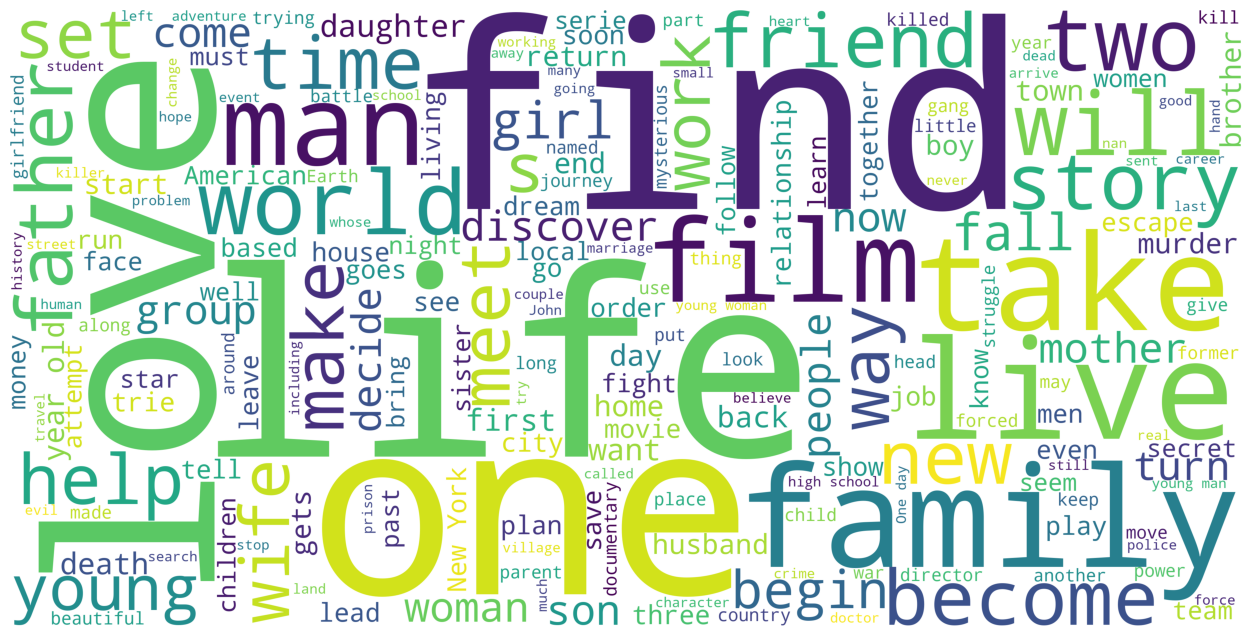

In [19]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

The most commonly used word in movie titles is Life. One and Find are also popular in Movie Blurbs.

### Popularity, Vote Average and Vote Count

We will be working with metrics that TMDB users have sent us in this section. Along with other numerical features like budget and revenue, we will attempt to better comprehend the popularity, vote average, and vote count features and try to deduce any relationships between them.


In [20]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [21]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

In [22]:
df['popularity'].describe()

count    45460.000000
mean         2.921478
std          6.005414
min          0.000000
25%          0.385948
50%          1.127685
75%          3.678902
max        547.488298
Name: popularity, dtype: float64

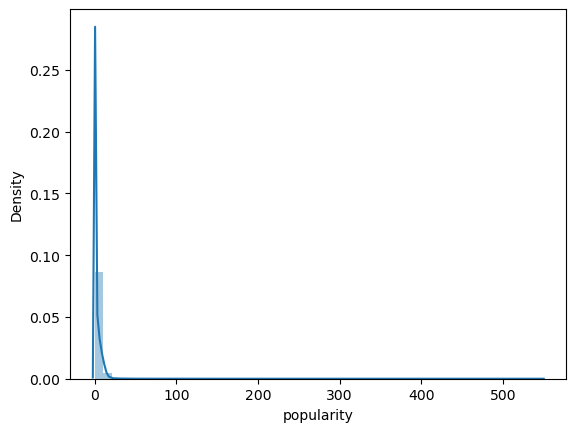

In [23]:
sns.distplot(df['popularity'].fillna(df['popularity'].median()))
plt.show()

<Axes: ylabel='Frequency'>

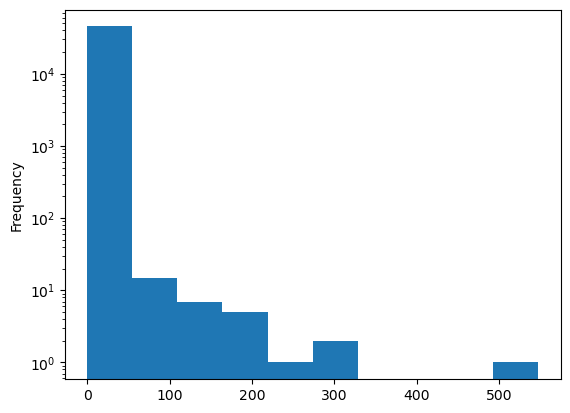

In [24]:
df['popularity'].plot(logy=True, kind='hist')

The Popularity score shows an extreme skewness, with a mean of only 2.9 and maximum values up to 547—nearly 1800% higher than the mean. However, the distribution map shows that practically all films have a popularity score below 10 (3.678902 is the 75th percentile).


### Relationship between popularity and vote average

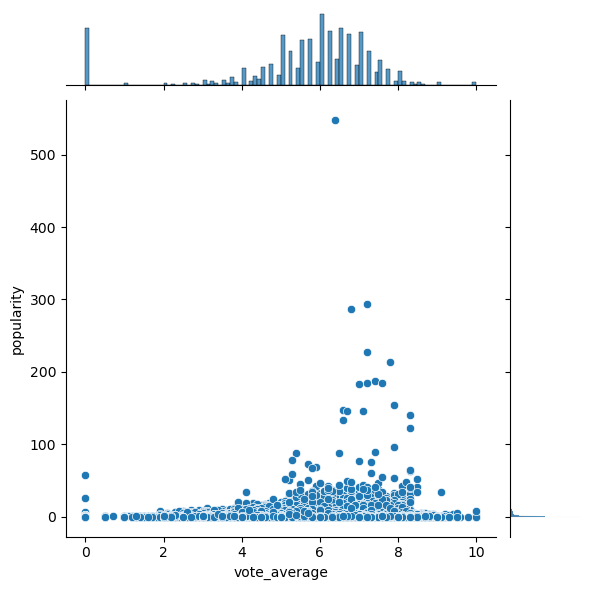

In [25]:
sns.jointplot(x='vote_average', y='popularity', data=df)

Interestingly, there appears to be no discernible correlation as the Pearson Coefficient of the two previously mentioned features is only 0.097. Put differently, the average of popularity and votes and independent quantities. Finding out how TMDB rates the popularity of each of their films on a numerical scale would be interesting.


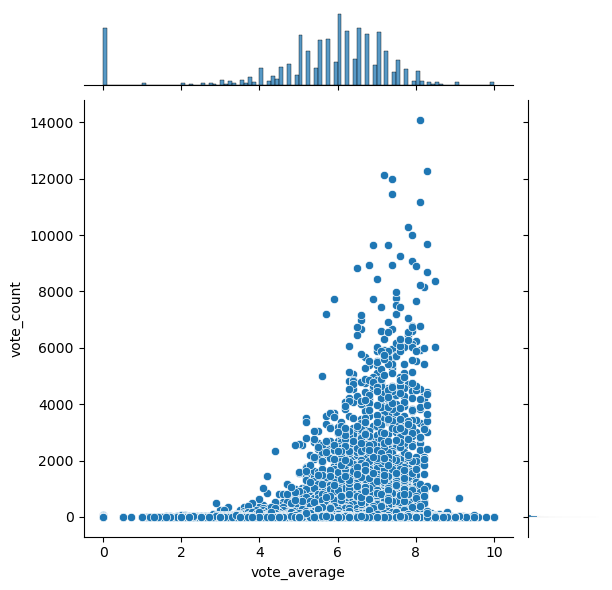

In [26]:
sns.jointplot(x='vote_average', y='vote_count', data=df)

The correlation between the features Vote Count and Vote Average is very small. A film does not always indicate that it is good just because it has received a lot of votes.

# Modelling

## Simple Recommendation System

##### This model's implementation is relatively simple. 
##### All we have to do is sort our movies by rating and popularity and display the top films on our list. 
##### As an extra step, we can include a genre argument to get the top movies in a specific genre.

In [27]:
df['genres'] = df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

### Top Movie Chart Generation

In [28]:
vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [29]:
m = vote_counts.quantile(0.95)
m

434.0

In [30]:
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [31]:
qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

Therefore, for a movie to be on the chart, it has to have at least 434 votes on TMDB. It is also seen that the average rating for a movie on TMDB is 5.244 on a scale of 10. The number of movies that can appear on the chart is 2274.

### Weighted Rating

In [32]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [33]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [34]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [35]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


### Genre-Based Recommendations

In this section, we are going to construct a function that builds charts for particular genres. Relaxing the default conditions to the 85th percentile instead of 95, will help us achieve our aim.

In [36]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_df = df.drop('genres', axis=1).join(s)

In [37]:
def build_chart(genre, percentile=0.85):
    df = gen_df[gen_df['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

Let's test the function

In [38]:
build_chart('Action').head(15)

,title,year,vote_count,vote_average,popularity,wr
15480,Inception,2010,14075,8,29.108149,7.955099
12481,The Dark Knight,2008,12269,8,123.167259,7.948610
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,7.929579
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,7.924031
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,7.918382
256,Star Wars,1977,6778,8,42.149697,7.908327
1154,The Empire Strikes Back,1980,5998,8,19.470959,7.896841
4135,Scarface,1983,3017,8,11.299673,7.802046
9430,Oldboy,2003,2000,8,10.616859,7.711649
1910,Seven Samurai,1954,892,8,15.017770,7.426145


## Content-Based Filtering

For the building of this model, we will be using a subset of all the movies available to us due to limiting computing power at our disposal.

In [39]:
links_small = pd.read_csv('D:\APU\Semester 3\CP2\Dataset\movies_dataset\links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [40]:
df = df.drop([19730, 29503, 35587])

In [41]:
df['id'] = df['id'].astype('int')

In [42]:
sdf = df[df['id'].isin(links_small)]
sdf.shape

(9099, 23)

There are 9099 movies avaiable in the small movies metadata dataset which is 5 times smaller than the original dataset.

### CBF Based on Movie Description Using Cosine Similarity

In [43]:
sdf['tagline'] = sdf['tagline'].fillna('')
sdf['description'] = sdf['overview'] + sdf['tagline']
sdf['description'] = sdf['description'].fillna('')

In [44]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=1, stop_words='english')
tfidf_matrix = tf.fit_transform(sdf['description'])

In [45]:
tfidf_matrix.shape

(9099, 268124)

Since the TF-IDF Vectorizer was used, calculating the Dot Product will directly give the Cosine Similarity score. Therefore, sklearn's linear_kernel will be used instead of cosine_similarities since it is much faster.

In [46]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [47]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

Now, there is a pairwise cosine similarity matrix for all the movies in the dataset. The next step will be to build a function that shows the 30 most similar movies based on the cosine similarity score.

In [48]:
sdf = sdf.reset_index()
titles = sdf['title']
indices = pd.Series(sdf.index, index=sdf['title'])

In [49]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Let's test the function

In [50]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

In [51]:
get_recommendations('Toy Story').head(10)

2502               Toy Story 2
7535               Toy Story 3
6193    The 40 Year Old Virgin
2547           Man on the Moon
6627              Factory Girl
4702    What's Up, Tiger Lily?
889      Rebel Without a Cause
6554    For Your Consideration
4988          Rivers and Tides
1599                 Condorman
Name: title, dtype: object

We see that for Toy Story, the system is able to identify it as a movie from the franchise Toy Story and therefore recommend other Toy Story films as its top recommendations. But unfortunately, that is all this system is able to do at the moment. This doesn't really help much because it ignores crucial elements that affect a movie's popularity and rating, like cast, crew, director, and genre.

Someone who liked Toy Story probably likes it more because it's a pixar movie produced by director John Lasseter and would not like that much "What's Up, Tiger Lily?" or every other movie in the list that is not from pixar and produced by John Lasseter.

Therefore, more suggestive metadata are going to be used. In the next part will be built a more advanced RS that takes genre, keywords, cast and crew into consideration.

### CBF Based on Metadata

In [52]:
credits = pd.read_csv('D:\APU\Semester 3\CP2\Dataset\movies_dataset\credits.csv')
keywords = pd.read_csv('D:\APU\Semester 3\CP2\Dataset\movies_dataset\keywords.csv')

In [53]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
df['id'] = df['id'].astype('int')

In [54]:
df.shape

(45463, 23)

In [55]:
df = df.merge(credits, on='id')
df = df.merge(keywords, on='id')

In [56]:
sdf = df[df['id'].isin(links_small)]
sdf.shape

(9219, 26)

Now that we have cast, crew, genres and credits, all in one dataframe, here is how we are going to proceed:

- Crew: Only the director will be picked since the others don't contribute that much to the feel of the movie.

- Cast: Cast selection is a little trickier. Minor roles and lesser-known performers don't actually change people's perceptions of a film. We can only choose the main characters and the actors who play them. We shall select the top three actors listed in the credits at random.

In [57]:
sdf['cast'] = sdf['cast'].apply(literal_eval)
sdf['crew'] = sdf['crew'].apply(literal_eval)
sdf['keywords'] = sdf['keywords'].apply(literal_eval)
sdf['cast_size'] = sdf['cast'].apply(lambda x: len(x))
sdf['crew_size'] = sdf['crew'].apply(lambda x: len(x))

In [58]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [59]:
sdf['director'] = sdf['crew'].apply(get_director)

In [60]:
sdf['cast'] = sdf['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
sdf['cast'] = sdf['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [61]:
sdf['keywords'] = sdf['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

The approach to build the RS is going to be a bit clumsy. The goal here isto compile a metadata dump of all the films, including the principal actors, director, genres, and keywords. Then, just like we did with the Description RS, we will utilize a Count Vectorizer to generate our count matrix. The subsequent steps are the same as in the previous section: we compute the cosine similarity and return the most comparable movies.

Hese are the steps we are going to follow to prepare the features genres and credits:

- Remove spaces and change all of our features to lowercase. In this manner, Johnny Depp and Johnny Galecki won't be confused by the system.

- To give the director additional weight in relation to the full cast, mention it three times.


In [62]:
sdf['cast'] = sdf['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [63]:
sdf['director'] = sdf['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
sdf['director'] = sdf['director'].apply(lambda x: [x,x, x])

#### Preprocessing of keywords

In [64]:
s = sdf.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [65]:
s = s.value_counts()
s[:5]

keyword
independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: count, dtype: int64

Frequencies of keywords range from 1 to 610. Keywords that appear only once are not useful to us. Consequently, it is safe to remove these. Ultimately, each word will be reduced to its stem, treating terms like "dogs" and "dog" equally.


In [66]:
s = s[s > 1]

In [67]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [68]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [69]:
sdf['keywords'] = sdf['keywords'].apply(filter_keywords)
sdf['keywords'] = sdf['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
sdf['keywords'] = sdf['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [70]:
sdf['soup'] = sdf['keywords'] + sdf['cast'] + sdf['director'] + sdf['genres']
sdf['soup'] = sdf['soup'].apply(lambda x: ' '.join(x))

In [71]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=1, stop_words='english')
count_matrix = count.fit_transform(sdf['soup'])

In [72]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [73]:
sdf = sdf.reset_index()
titles = sdf['title']
indices = pd.Series(sdf.index, index=sdf['title'])

Let's reuse the get_recommendations function that we built earlier. Since the cosine similarity scores have changed, it is expected to have different (and probably better) results. Let us check for The Toy Story again and see what recommendations we get this time.

In [74]:
get_recommendations('Toy Story').head(10)

6386                Luxo Jr.
2522             Toy Story 2
7914                  Cars 2
6496                    Cars
1883            A Bug's Life
8519    Toy Story of Terror!
7629             Toy Story 3
2751       Creature Comforts
3833          Monsters, Inc.
1432        Meet the Deedles
Name: title, dtype: object

In [75]:
get_recommendations('Toy Story').head(10)

6386                Luxo Jr.
2522             Toy Story 2
7914                  Cars 2
6496                    Cars
1883            A Bug's Life
8519    Toy Story of Terror!
7629             Toy Story 3
2751       Creature Comforts
3833          Monsters, Inc.
1432        Meet the Deedles
Name: title, dtype: object

This time, the results are much more satisfying. The recommendations seems to have recognized other pixar movies produced by john Lasseter

#### Popularity and Ratings

One thing that is noticed about the RS we built, is that it recommends movies regardless of ratings and popularity. It is true that Luxo Jr. has a lot of similarity with Toy Story but it wasn't that good.

Therefore, a mechanism will be added to remove movies with bad ratings and return movies that have a better critical response.

The top 25 movies will be taken, based on similarity scores, and the vote of the 60th percentile movie will be calculated. Then, we will use the IMDB method to determine each movie's weighted rating, just as we did in the Simple Recommender section, using this as the value of m.

In [76]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = sdf.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [248]:
improved_recommendations('Toy Story')

,title,vote_count,vote_average,year,wr
3833,"Monsters, Inc.",6150,7,2001,6.884308
7629,Toy Story 3,4710,7,2010,6.851922
2522,Toy Story 2,3914,7,1999,6.824813
8595,The Lego Movie,3127,7,2014,6.786095
6496,Cars,3991,6,2006,5.925940
1883,A Bug's Life,2379,6,1998,5.883500
7404,Cloudy with a Chance of Meatballs,1799,6,2009,5.853240
1832,Antz,1320,6,1998,5.813161
3016,Chicken Run,1190,6,2000,5.798205
7914,Cars 2,2088,5,2011,5.042143


## Collaborative Filtering Using Surprise Library

The CBF model we built, suffers from some severe limitations. It can only suggest movies which are similar to a certain movie, which means it is not capable of capturing tastes and providing recommendations across genres.

Also, the model we built is not really personalized in that it doesn't capture the personal tastes and biases of a user. Anyone using that model for recommendations based on a movie will receive the same recommendations for that movie, regardless of who they are.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to users.

We won't implement CF from scratch. Instead, we will use the Surprise library that used extremely powerful algorithms and provides great recommendations.

In [78]:
reader = Reader(rating_scale=(1, 5))

In [79]:
ratings = pd.read_csv('D:/APU/Semester 3/CP2/Dataset/movies_dataset/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [80]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

#### Different Prediction Algorithms

In [81]:
algo = NormalPredictor()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4411  1.4311  1.4255  1.4301  1.4370  1.4330  0.0055  
MAE (testset)     1.1507  1.1411  1.1398  1.1429  1.1500  1.1449  0.0046  
Fit time          0.08    0.10    0.11    0.09    0.10    0.10    0.01    
Test time         0.07    0.07    0.06    0.07    0.09    0.07    0.01    


{'test_rmse': array([1.44114035, 1.43110936, 1.4255186 , 1.43014177, 1.43704201]),
 'test_mae': array([1.15066113, 1.14114156, 1.13976017, 1.14287987, 1.15004366]),
 'fit_time': (0.08173155784606934,
  0.09950947761535645,
  0.1108865737915039,
  0.09486842155456543,
  0.09605693817138672),
 'test_time': (0.06797575950622559,
  0.06955385208129883,
  0.0644533634185791,
  0.06953954696655273,
  0.09333109855651855)}

In [82]:
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9007  0.8971  0.8944  0.9003  0.8925  0.8970  0.0032  
MAE (testset)     0.6919  0.6859  0.6917  0.6954  0.6889  0.6907  0.0032  
Fit time          1.22    1.01    0.94    0.94    1.27    1.08    0.14    
Test time         0.11    0.38    0.10    0.12    0.10    0.16    0.11    


{'test_rmse': array([0.90066211, 0.89709937, 0.89444278, 0.90030415, 0.89246799]),
 'test_mae': array([0.69188429, 0.68590383, 0.69165452, 0.69540179, 0.6888571 ]),
 'fit_time': (1.222360372543335,
  1.0051288604736328,
  0.9391562938690186,
  0.9435737133026123,
  1.2666239738464355),
 'test_time': (0.10968303680419922,
  0.37591123580932617,
  0.1035768985748291,
  0.11650419235229492,
  0.09983372688293457)}

In [83]:
algo = KNNBasic(k=20)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9608  0.9629  0.9552  0.9630  0.9610  0.9606  0.0029  
MAE (testset)     0.7375  0.7375  0.7326  0.7377  0.7366  0.7364  0.0019  
Fit time          0.23    0.20    0.18    0.21    0.22    0.21    0.02    
Test time         0.92    0.87    0.92    1.01    1.01    0.94    0.06    


{'test_rmse': array([0.96079629, 0.96287819, 0.95515143, 0.96301889, 0.96104099]),
 'test_mae': array([0.73753697, 0.7374824 , 0.73256636, 0.73766863, 0.73661376]),
 'fit_time': (0.226578950881958,
  0.19701075553894043,
  0.1829209327697754,
  0.21483063697814941,
  0.2183225154876709),
 'test_time': (0.9171741008758545,
  0.8685271739959717,
  0.9205105304718018,
  1.0098953247070312,
  1.0078835487365723)}

In [84]:
algo = KNNBasic(sim_options={'user_based': False} , k=20) 
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9423  0.9447  0.9462  0.9534  0.9480  0.9469  0.0037  
MAE (testset)     0.7291  0.7302  0.7306  0.7375  0.7335  0.7322  0.0030  
Fit time          3.11    2.98    3.13    2.94    2.98    3.03    0.08    
Test time         4.13    4.21    4.50    3.89    4.31    4.21    0.20    


{'test_rmse': array([0.94232959, 0.94473185, 0.9462398 , 0.95340698, 0.94801082]),
 'test_mae': array([0.72905591, 0.73022735, 0.73063249, 0.73753334, 0.73351321]),
 'fit_time': (3.1138339042663574,
  2.9788978099823,
  3.1286721229553223,
  2.9359066486358643,
  2.9801788330078125),
 'test_time': (4.133277654647827,
  4.206097841262817,
  4.504145860671997,
  3.8890151977539062,
  4.310917854309082)}

In [85]:
algo = NMF()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9470  0.9419  0.9510  0.9491  0.9427  0.9463  0.0035  
MAE (testset)     0.7258  0.7237  0.7290  0.7291  0.7231  0.7261  0.0025  
Fit time          1.97    1.86    1.88    1.83    1.97    1.90    0.06    
Test time         0.08    0.09    0.09    0.33    0.10    0.14    0.10    


{'test_rmse': array([0.94703545, 0.94193502, 0.95096857, 0.94909176, 0.94268009]),
 'test_mae': array([0.72578335, 0.7237481 , 0.72898677, 0.72910253, 0.7231149 ]),
 'fit_time': (1.9652938842773438,
  1.8601689338684082,
  1.8789851665496826,
  1.8287250995635986,
  1.9703269004821777),
 'test_time': (0.08038663864135742,
  0.08782482147216797,
  0.09443306922912598,
  0.3303794860839844,
  0.09670114517211914)}

Parameters:

- n_factors – The number of factors. Default is 100.
- n_epochs – The number of iteration of the SGD procedure. Default is 20.
- init_mean – The mean of the normal distribution for factor vectors initialization. Default is 0.
- init_std_dev – The standard deviation of the normal distribution for factor vectors initialization. Default is 0.1.
- lr_all – The learning rate for all parameters. Default is 0.005.
- reg_all – The regularization term for all parameters. Default is 0.02.

### Predictions

In [86]:
sup_train = data.build_full_trainset()
algo = SVD(n_factors = 200 , lr_all = 0.005 , reg_all = 0.02 , n_epochs = 40 , init_std_dev = 0.05)
algo.fit(sup_train)

In [87]:
def prediction_algo(uid = None , iid = None):
    predictions = []
    if uid is None:
        for ui in sup_train.all_users():
            predictions.append(algo.predict(ui, iid, verbose = False))
        return predictions
    
    if iid is None:
        for ii in sup_train.all_items():
            ii = sup_train.to_raw_iid(ii)
            predictions.append(algo.predict(uid, ii, verbose = False))
        return predictions
    return predictins.append(algo.predict(uid,iid,verbose = False))

In [88]:
predictions = prediction_algo(uid = 112)
predictions.sort(key=lambda x: x.est, reverse=True)
print('#### Best Recommanded Movies are ####')
for pred in predictions[:21]:
#     print('Movie -> {} with Score-> {}'.format(sup_train.to_raw_iid(pred.iid) , pred.est))
    print('Movie -> {} with Score-> {}'.format(pred.iid, pred.est))

#### Best Recommanded Movies are ####
Movie -> 858 with Score-> 5
Movie -> 318 with Score-> 4.984646154679105
Movie -> 926 with Score-> 4.9830535689677475
Movie -> 58559 with Score-> 4.978057325817336
Movie -> 1198 with Score-> 4.9595942904916726
Movie -> 904 with Score-> 4.939472907110806
Movie -> 969 with Score-> 4.933167682366248
Movie -> 8132 with Score-> 4.918165740594564
Movie -> 1221 with Score-> 4.888493313266158
Movie -> 1276 with Score-> 4.875757105701794
Movie -> 905 with Score-> 4.871011438017856
Movie -> 908 with Score-> 4.869489664018273
Movie -> 2318 with Score-> 4.865858750532207
Movie -> 7153 with Score-> 4.862828803663523
Movie -> 1228 with Score-> 4.858582804907116
Movie -> 608 with Score-> 4.857745219444625
Movie -> 7502 with Score-> 4.846858565051648
Movie -> 527 with Score-> 4.827260864081795
Movie -> 2959 with Score-> 4.822774382979987
Movie -> 1196 with Score-> 4.817320934917773
Movie -> 2542 with Score-> 4.806535174983916


## Hybrid Filtering

After building the CBF and CF models, we are going to build a simple hybrid recommendation system that brings together techniques that were implemented in both CBF and CF. This is how it is going to work:

- Input: User ID and the Title of a Movie
- Output: Similar movies sorted on the basis of expected ratings by that particular user.

In [89]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [90]:
id_map = pd.read_csv('D:/APU/Semester 3/CP2/Dataset/movies_dataset/links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(sdf[['title', 'id']], on='id').set_index('title')

In [91]:
indices_map = id_map.set_index('id')

In [245]:
def hybrid(userId, title):
    idx = indices.loc[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = sdf.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: algo.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [246]:
hybrid(500, 'Toy Story')

,title,vote_count,vote_average,year,id,est
8595,The Lego Movie,3127.0,7.5,2014,137106,3.696191
7404,Cloudy with a Chance of Meatballs,1799.0,6.5,2009,22794,3.517194
6496,Cars,3991.0,6.6,2006,920,3.494501
7169,A Matter of Loaf and Death,120.0,7.2,2008,14447,3.380401
2751,Creature Comforts,29.0,7.3,1989,54825,3.310335
4341,"The Looney, Looney, Looney Bugs Bunny Movie",13.0,6.6,1981,41394,3.280914
5287,"Bon Voyage, Charlie Brown (and Don't Come Back!)",12.0,6.2,1980,31112,3.217377
8519,Toy Story of Terror!,246.0,7.3,2013,213121,3.178203
7254,Kung Fu Panda: Secrets of the Furious Five,80.0,6.5,2008,15854,3.178143
6386,Luxo Jr.,148.0,7.1,1986,13925,3.094135


In [194]:
hybrid(500, 'The Godfather')

,title,vote_count,vote_average,year,id,est
284,The Shawshank Redemption,8358.0,8.5,1994,278,4.408302
2998,The Conversation,377.0,7.5,1974,592,3.697823
2742,...And Justice for All,118.0,7.1,1979,17443,3.543748
2808,Midnight Express,309.0,7.6,1978,11327,3.352389
868,Looking for Richard,33.0,6.9,1996,42314,3.249642
1346,The Rainmaker,239.0,6.7,1997,11975,3.249590
146,Feast of July,0.0,0.0,1995,259209,3.173461
4148,The Gambler,21.0,7.0,1974,44800,3.170847
1765,The Paradine Case,42.0,6.3,1947,31667,3.163830
1100,Dracula,1087.0,7.1,1992,6114,3.157276


It can be seen that for our hybrid RS, we get different recommendations for different users although the movie is the same. Hence, the recommendations are more personalized and tailored towards particular users.

In [95]:
import pickle

In [123]:
pickle.dump(sdf,open('sdf.pkl','wb'))
pickle.dump(indices,open('indices.pkl','wb'))
pickle.dump(id_map,open('id_map.pkl','wb'))
pickle.dump(indices_map,open('indices_map.pkl','wb'))
pickle.dump(cosine_sim,open('cosine_sim.pkl','wb')) 
pickle.dump(indices.to_dict(),open('title.pkl','wb'))

In [231]:
sdf['poster_path']

0       /rhIRbceoE9lR4veEXuwCC2wARtG.jpg
1       /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg
2       /6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg
3       /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg
4       /e64sOI48hQXyru7naBFyssKFxVd.jpg
                      ...               
9214    /yWp7PgydSlxlhl7benKhTnCvRjN.jpg
9215    /q1lrN6ZrIsOs077lQB86aPGKZRF.jpg
9216    /q2XVemXiWSa18mbaVpI3rbLXG2u.jpg
9217    /8YWirGQidtZeSEmhqvQM5FrI6N1.jpg
9218    /uv7syi4vRyjvWoB8qExbqnbuCu5.jpg
Name: poster_path, Length: 9219, dtype: object

In [242]:
sdf['id']

0          862
1         8844
2        15602
3        31357
4        11862
         ...  
9214    159550
9215    392572
9216    402672
9217    315011
9218    391698
Name: id, Length: 9219, dtype: int32

In [247]:
cosine_sim

array([[1.        , 0.02441931, 0.02738955, ..., 0.        , 0.        ,
        0.        ],
       [0.02441931, 1.        , 0.        , ..., 0.02973505, 0.02500782,
        0.        ],
       [0.02738955, 0.        , 1.        , ..., 0.03335187, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02973505, 0.03335187, ..., 1.        , 0.08700222,
        0.        ],
       [0.        , 0.02500782, 0.        , ..., 0.08700222, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])